In [1]:
import data_analysis_utilitites as da_utilities
import data_analysis_areas as da_area

In [6]:
data = data_analysis_utilities.load_df_from_parquet('data_trimmed.parquet')

DataFrame successfully loaded from /home/bellijjy/data_trimmed.parquet


In [7]:
data

,area,state,day,epoch,time_chunk,tau,branching_factor,data,dt
animal,,,,,,,,,
_con,CA3,sleep,4,5,31,809.383114,0.998765,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000434
_con,CA3,wake,5,4,26,407.667742,0.997550,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000434
_con,CA3,wake,3,2,4,381.053557,0.997379,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000467
_con,CA1,sleep,1,5,19,122.227841,0.991852,"[0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",1.000434
_con,CA3,sleep,2,1,6,13.013210,0.926033,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000434
...,...,...,...,...,...,...,...,...,...
_cha,CA1,sleep,4,3,29,6.195645,0.850948,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000
_cha,CA1,wake,2,4,6,112.422062,0.991144,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0.999967
_cha,CA3,sleep,5,3,10,9.780898,0.902813,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1.000000


In [12]:
from scipy.stats import spearmanr

#for the assumptions of the wilcoxon-signed-rank test
def check_independence_within_pairs_index(data, state1, state2, dv_col='tau'):
    """
    Check for independence within pairs of observations for two states using Spearman's rank correlation.
    Assumes that 'animal' is the index of the DataFrame.
    
    Parameters:
        data (DataFrame): The data containing the measurements.
        state1 (str): The name of the first state.
        state2 (str): The name of the second state.
        dv_col (str): The column name for the dependent variable.

    Returns:
        None: Prints the Spearman's rank correlation coefficient and p-value for each subject.
    """
    
    # Filter the data for each state
    data_state1 = data[data['area'] == state1]
    data_state2 = data[data['area'] == state2]
    
    # Get the list of unique subjects (assuming 'animal' is the index)
    unique_subjects = data.index.unique()
    
    for subject in unique_subjects:
        # Extract the tau values for the specific subject and each state
        tau_values_state1 = data_state1.loc[subject, dv_col].values if subject in data_state1.index else []
        tau_values_state2 = data_state2.loc[subject, dv_col].values if subject in data_state2.index else []
        
        # Ensure there are an equal number of observations for both states
        min_len = min(len(tau_values_state1), len(tau_values_state2))
        if min_len == 0:
            print(f"No data available for subject {subject}. Skipping...")
            continue

        tau_values_state1 = tau_values_state1[:min_len]
        tau_values_state2 = tau_values_state2[:min_len]
        
        # Calculate Spearman's rank correlation
        coef, p = spearmanr(tau_values_state1, tau_values_state2)
        
        if p < 0.05:
            print(f"Subject {subject}: Spearman's rank correlation coefficient = {coef:.2f}, p = {p:.2f}.")
            print("Caution: The p-value suggests that the two sets of observations are not independent.")
        else:
            print(f"Subject {subject}: Spearman's rank correlation coefficient = {coef:.2f}, p = {p:.2f}.")
            print("The p-value suggests that the two sets of observations are independent.")

# Commented out the function call as the sample data is not provided
check_independence_within_pairs_index(data, 'CA1', 'CA3')

Subject _con: Spearman's rank correlation coefficient = -0.07, p = 0.12.
The p-value suggests that the two sets of observations are independent.
Subject _dav: Spearman's rank correlation coefficient = 0.03, p = 0.61.
The p-value suggests that the two sets of observations are independent.
Subject _dud: Spearman's rank correlation coefficient = 0.07, p = 0.12.
The p-value suggests that the two sets of observations are independent.
Subject _Cor: Spearman's rank correlation coefficient = -0.06, p = 0.34.
The p-value suggests that the two sets of observations are independent.
Subject _cha: Spearman's rank correlation coefficient = 0.06, p = 0.52.
The p-value suggests that the two sets of observations are independent.


In [13]:
from scipy.stats import shapiro

#checking for symmetry of distribution of differences of pairs (shapiro wilk is sufficient but not necessary, QQ-can also help)
def check_wilcoxon_assumptions_index(data, state1, state2, dv_col='tau'):
    """
    Automatically check the assumptions for the Wilcoxon Signed-Rank Test using statistical packages.
    Assumes that 'animal' is the index of the DataFrame.
    
    Parameters:
        data (DataFrame): The data containing the measurements.
        state1 (str): The name of the first state.
        state2 (str): The name of the second state.
        dv_col (str): The column name for the dependent variable.

    Returns:
        None: Prints the results of the assumption checks.
    """
    
    # Filter the data for each state
    data_state1 = data[data['area'] == state1]
    data_state2 = data[data['area'] == state2]
    
    # Get the list of unique subjects (assuming 'animal' is the index)
    unique_subjects = data.index.unique()
    
    for subject in unique_subjects:
        # Extract the tau values for the specific subject and each state
        tau_values_state1 = data_state1.loc[subject, dv_col].values if subject in data_state1.index else []
        tau_values_state2 = data_state2.loc[subject, dv_col].values if subject in data_state2.index else []
        
        # Ensure there are an equal number of observations for both states
        min_len = min(len(tau_values_state1), len(tau_values_state2))
        if min_len == 0:
            print(f"No data available for subject {subject}. Skipping...")
            continue
        print(f"Subject {subject}: Difference in number of data points = {abs(len(tau_values_state1) - len(tau_values_state2))}")

        tau_values_state1 = tau_values_state1[:min_len]
        tau_values_state2 = tau_values_state2[:min_len]
        
        # Calculate the differences
        differences = tau_values_state1 - tau_values_state2
        
        
        # Check for normality (Shapiro-Wilk test)
        stat, p = shapiro(differences)
        print(p)
        if p > 0.05:
            print(f"Subject {subject}: The distribution of differences passes the Shapiro-Wilk normality test (p = {p:.2f}).")
        else:
            print(f"Subject {subject}: The distribution of differences fails the Shapiro-Wilk normality test (p = {p:.2f}).")
            

# Commented out the function call as the sample data is not provided
check_wilcoxon_assumptions_index(data, 'CA1', 'CA3')

Subject _con: Difference in number of data points = 488
1.9669616989055703e-15
Subject _con: The distribution of differences fails the Shapiro-Wilk normality test (p = 0.00).
Subject _dav: Difference in number of data points = 164
8.412910125488171e-12
Subject _dav: The distribution of differences fails the Shapiro-Wilk normality test (p = 0.00).
Subject _dud: Difference in number of data points = 340
3.7123735035132924e-25
Subject _dud: The distribution of differences fails the Shapiro-Wilk normality test (p = 0.00).
Subject _Cor: Difference in number of data points = 448
8.510157097248172e-13
Subject _Cor: The distribution of differences fails the Shapiro-Wilk normality test (p = 0.00).
Subject _cha: Difference in number of data points = 215
5.046421165388892e-07
Subject _cha: The distribution of differences fails the Shapiro-Wilk normality test (p = 0.00).


In [15]:
from scipy.stats import friedmanchisquare, wilcoxon, probplot
from IPython.display import display, Latex
import matplotlib.pyplot as plt
import seaborn as sns

def state_difference_friedman_wilcoxon_individual(data, within_col='area', dv_col='tau', states=None, alpha=0.05):
    """
    Modified function to handle Friedman and Wilcoxon tests when 'animal' is the index.
    This version gives results for each subject individually.
    
    Parameters:
        data (DataFrame): The data containing the measurements.
        within_col (str): The column name for the within-subjects variable (e.g., 'area').
        dv_col (str): The column name for the dependent variable (e.g., 'tau').
        states (list): Optional list of states to consider.
        alpha (float): Significance level for Bonferroni correction.

    Returns:
        None: Displays the results of Friedman or Wilcoxon tests and plots.
    """
    
    unique_states = data[within_col].unique() if states is None else states
    unique_subjects = data.index.unique()
    
    # Bonferroni correction
    corrected_alpha = alpha / len(unique_subjects)
    
    for subject in unique_subjects:
        subject_data = data.loc[subject]
        
        if len(unique_states) >= 3:
            # Friedman test
            try:
                friedman_data = [subject_data[subject_data[within_col] == state][dv_col].values for state in unique_states]
                chi2, p_value = friedmanchisquare(*friedman_data)
                display(Latex(f"Subject {subject}: Friedman Test: \( \chi^2 = {chi2:.4f}, p = {p_value:.4f} \)"))
            except Exception as e:
                print(f"Subject {subject}: An error occurred while performing the Friedman Test: {e}")
        elif len(unique_states) == 2:
            # Wilcoxon signed-rank test
            try:
                state1_data = subject_data[subject_data[within_col] == unique_states[0]][dv_col].values
                state2_data = subject_data[subject_data[within_col] == unique_states[1]][dv_col].values
                
                if len(state1_data) != len(state2_data):
                    print(f"Subject {subject}: Difference in number of data points = {abs(len(state1_data) - len(state2_data))}")
                    
                    min_len = min(len(state1_data), len(state2_data))
                    state1_data = state1_data[:min_len]
                    state2_data = state2_data[:min_len]
                
                stat, p_value = wilcoxon(state1_data, state2_data)
                is_significant = "Yes" if p_value < corrected_alpha else "No"
                display(Latex(f"Subject {subject}: Wilcoxon Signed-Rank Test: \( W = {stat:.4f}, p = {p_value:.4f} \)"))
                display(Latex(f"Bonferroni-Corrected Significance: {is_significant} (alpha = {corrected_alpha:.4f})"))
            except Exception as e:
                print(f"Subject {subject}: An error occurred while performing the Wilcoxon Signed-Rank Test: {e}")
        else:
            print(f"Subject {subject}: Insufficient number of states for statistical testing.")
            
# Commented out the function call as the sample data is not provided
state_difference_friedman_wilcoxon_individual(data)


Subject _con: Difference in number of data points = 488


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Subject _dav: Difference in number of data points = 164


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Subject _dud: Difference in number of data points = 340


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Subject _Cor: Difference in number of data points = 448


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Subject _cha: Difference in number of data points = 215


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Difference in number of data points = 897


<IPython.core.display.Latex object>

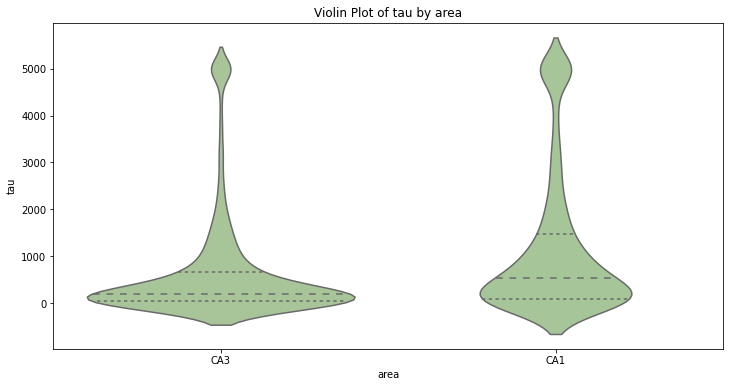

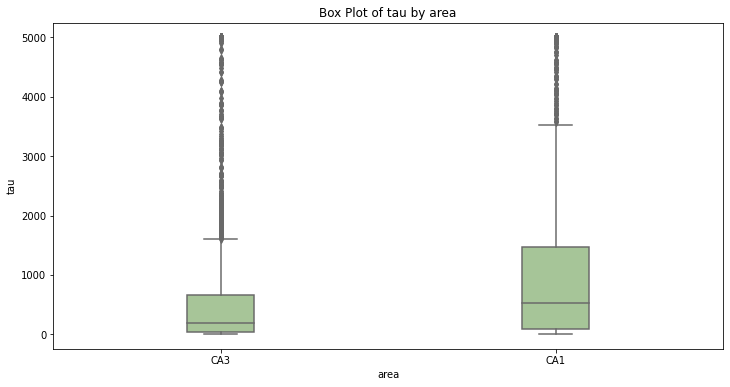

In [17]:
def state_difference_global_friedman_wilcoxon_modified_index(data, within_col='area', dv_col='tau', states=None):
    """
    Modified function to handle Friedman and Wilcoxon tests when 'animal' is the index.
    
    Parameters:
        data (DataFrame): The data containing the measurements.
        within_col (str): The column name for the within-subjects variable (e.g., 'area').
        dv_col (str): The column name for the dependent variable (e.g., 'tau').
        states (list): Optional list of states to consider.

    Returns:
        None: Displays the results of Friedman or Wilcoxon tests and plots.
    """
    
    # Check the number of unique states
    unique_states = data[within_col].unique() if states is None else states
    
    if len(unique_states) >= 3:
        # Friedman test
        try:
            friedman_data = [data[data[within_col] == state][dv_col].values for state in unique_states]
            chi2, p_value = friedmanchisquare(*friedman_data)
            display(Latex(f"Friedman Test: \( \chi^2 = {chi2:.4f}, p = {p_value:.4f} \)"))
        except Exception as e:
            print(f"An error occurred while performing the Friedman Test: {e}")
    elif len(unique_states) == 2:
        # Wilcoxon signed-rank test
        try:
            state1_data = data[data[within_col] == unique_states[0]][dv_col].values
            state2_data = data[data[within_col] == unique_states[1]][dv_col].values
            if len(state1_data) != len(state2_data):
                print(f"Difference in number of data points = {abs(len(state1_data) - len(state2_data))}")
                
                min_len = min(len(state1_data), len(state2_data))
                state1_data = state1_data[:min_len]
                state2_data = state2_data[:min_len]
            
            stat, p_value = wilcoxon(state1_data, state2_data)
            display(Latex(f"Wilcoxon Signed-Rank Test: \( W = {stat:.4f}, p = {p_value:.4f} \)"))
        except Exception as e:
            print(f"An error occurred while performing the Wilcoxon Signed-Rank Test: {e}")
    else:
        print("Insufficient number of states for statistical testing.")
        return

    # Create violin and box plots
    max_count = data[within_col].value_counts().max()
    cmap = plt.get_cmap('crest')
    colors = {state: cmap(i) for i, state in enumerate(unique_states)}
    
    # Violin Plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x=within_col, y=dv_col, data=data, inner='quartile', palette=colors)
    plt.title(f'Violin Plot of {dv_col} by {within_col}')
    plt.show()
    
    # Box Plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=within_col, y=dv_col, data=data, width=0.2, palette=colors)
    plt.title(f'Box Plot of {dv_col} by {within_col}')
    plt.show()

# Commented out the function call as the sample data is not provided
state_difference_global_friedman_wilcoxon_modified_index(data)

Subject _con: Difference in number of data points = 488
Before Box-Cox: Shapiro-Wilk p-value = 0.00


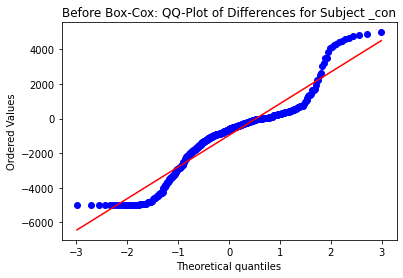

After Box-Cox: Shapiro-Wilk p-value = 0.00


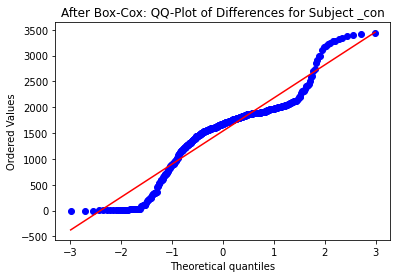

Subject _dav: Difference in number of data points = 164
Before Box-Cox: Shapiro-Wilk p-value = 0.00


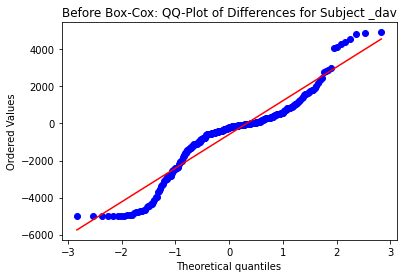

After Box-Cox: Shapiro-Wilk p-value = 0.00


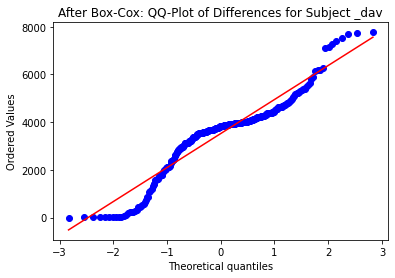

Subject _dud: Difference in number of data points = 340
Before Box-Cox: Shapiro-Wilk p-value = 0.00


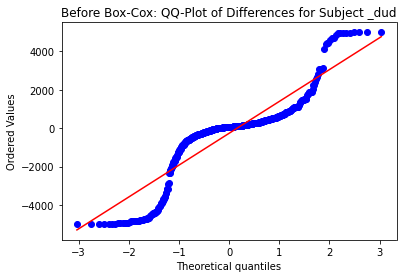

After Box-Cox: Shapiro-Wilk p-value = 0.00


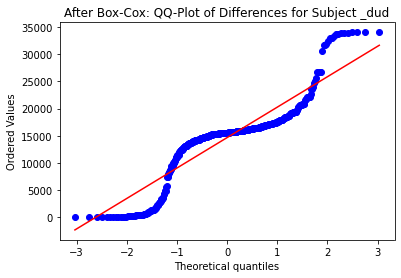

Subject _Cor: Difference in number of data points = 448
Before Box-Cox: Shapiro-Wilk p-value = 0.00


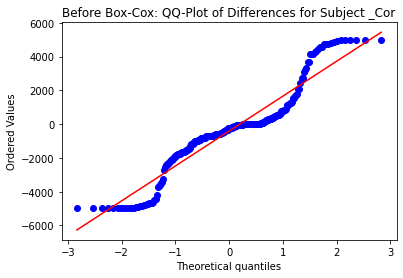

After Box-Cox: Shapiro-Wilk p-value = 0.00


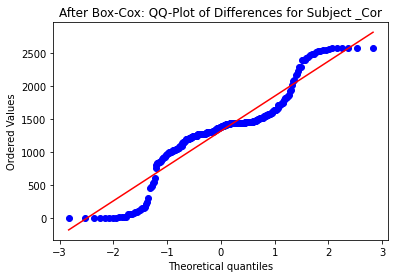

Subject _cha: Difference in number of data points = 215
Before Box-Cox: Shapiro-Wilk p-value = 0.00


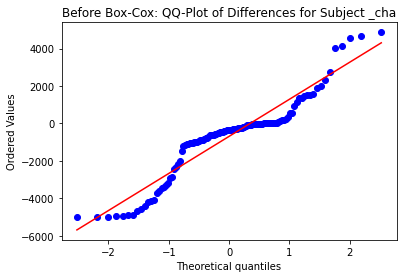

After Box-Cox: Shapiro-Wilk p-value = 0.00


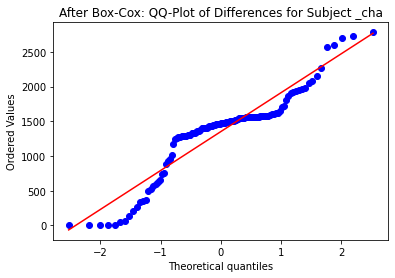

In [18]:
from scipy.stats import boxcox, shapiro

def check_wilcoxon_assumptions_with_boxcox(data, state1, state2, dv_col='tau'):
    """
    Automatically check the assumptions for the Wilcoxon Signed-Rank Test.
    Assumes that 'animal' is the index of the DataFrame.
    Extended to include QQ-plots, Shapiro-Wilk test, and Box-Cox transformation.
    
    Parameters:
        data (DataFrame): The data containing the measurements.
        state1 (str): The name of the first state.
        state2 (str): The name of the second state.
        dv_col (str): The column name for the dependent variable.

    Returns:
        None: Prints the results of the assumption checks and displays QQ-plots.
    """
    
    # Filter the data for each state
    data_state1 = data[data['area'] == state1]
    data_state2 = data[data['area'] == state2]
    
    # Get the list of unique subjects (assuming 'animal' is the index)
    unique_subjects = data.index.unique()
    
    for subject in unique_subjects:
        # Extract the tau values for the specific subject and each state
        tau_values_state1 = data_state1.loc[subject, dv_col].values if subject in data_state1.index else []
        tau_values_state2 = data_state2.loc[subject, dv_col].values if subject in data_state2.index else []
        
        # Print the difference in the number of data points for each state
        print(f"Subject {subject}: Difference in number of data points = {abs(len(tau_values_state1) - len(tau_values_state2))}")
        
        # Ensure there are an equal number of observations for both states
        min_len = min(len(tau_values_state1), len(tau_values_state2))
        if min_len == 0:
            print(f"No data available for subject {subject}. Skipping...")
            continue

        tau_values_state1 = tau_values_state1[:min_len]
        tau_values_state2 = tau_values_state2[:min_len]
        
        # Calculate the differences
        differences = tau_values_state1 - tau_values_state2
        
        # Check for normality (Shapiro-Wilk test)
        stat, p = shapiro(differences)
        print(f"Before Box-Cox: Shapiro-Wilk p-value = {p:.2f}")
            
        # QQ-plot for visual inspection of normality before Box-Cox
        plt.figure()
        probplot(differences, dist="norm", plot=plt)
        plt.title(f"Before Box-Cox: QQ-Plot of Differences for Subject {subject}")
        plt.show()
        
        # Apply Box-Cox transformation
        differences_boxcox, _ = boxcox(differences + abs(min(differences)) + 1)  # Shift to make all values positive
        
        # Check for normality post Box-Cox (Shapiro-Wilk test)
        stat, p = shapiro(differences_boxcox)
        print(f"After Box-Cox: Shapiro-Wilk p-value = {p:.2f}")
        
        # QQ-plot for visual inspection of normality after Box-Cox
        plt.figure()
        probplot(differences_boxcox, dist="norm", plot=plt)
        plt.title(f"After Box-Cox: QQ-Plot of Differences for Subject {subject}")
        plt.show()

# Commented out the function call as the sample data is not provided
check_wilcoxon_assumptions_with_boxcox(data, 'CA3', 'CA1')


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

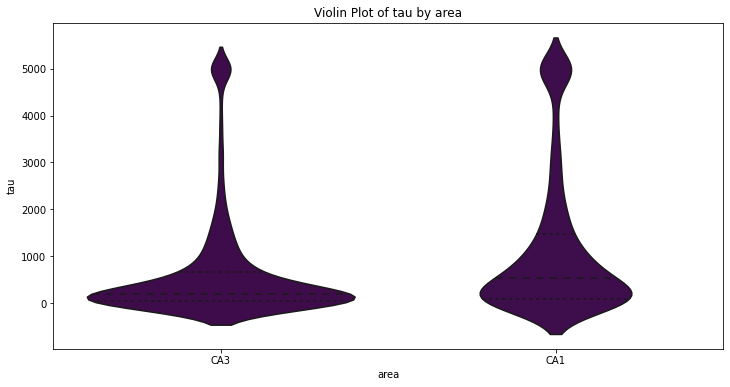

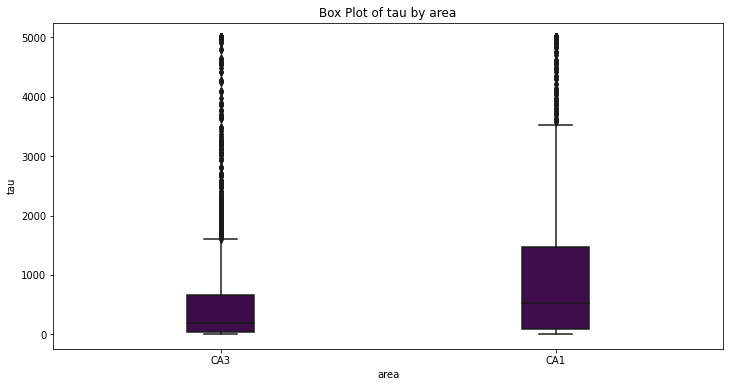

In [20]:
from IPython.display import display, Latex
from scipy.stats import binomtest
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def state_difference_global_sign_test_index_with_effect_size(data, within_col='area', dv_col='tau', states=None):
    """
    Modified function to handle Sign Test when 'animal' is the index. Also includes effect size calculation.
    
    Parameters:
        data (DataFrame): The data containing the measurements.
        within_col (str): The column name for the within-subjects variable (e.g., 'area').
        dv_col (str): The column name for the dependent variable (e.g., 'tau').
        states (list): Optional list of states to consider.

    Returns:
        None: Displays the results of Sign Test and effect size, and plots.
    """
    
    # Check the number of unique states
    unique_states = data[within_col].unique() if states is None else states
    
    if len(unique_states) != 2:
        print("The Sign Test requires exactly two states for comparison.")
        return
    
    state1, state2 = unique_states
    
    # Filter the data for each state
    data_state1 = data[data[within_col] == state1]
    data_state2 = data[data[within_col] == state2]
    
    # Initialize counters for the Sign Test
    N_pos = 0  # Number of positive differences
    N_neg = 0  # Number of negative differences
    N_zero = 0  # Number of zero differences
    
    # Loop through each unique subject (assuming 'animal' is the index)
    for idx in data.index.unique():
        
        # Extract individual observations for the specific subject and each state
        if idx in data_state1.index and idx in data_state2.index:
            observations_state1 = data_state1.loc[idx, dv_col]
            observations_state2 = data_state2.loc[idx, dv_col]

            # Make sure there's an equal number of observations for both states
            min_len = min(len(observations_state1), len(observations_state2))
            observations_state1 = observations_state1.iloc[:min_len]
            observations_state2 = observations_state2.iloc[:min_len]
            
            # Calculate the differences between the paired observations
            differences = observations_state1 - observations_state2
            
            # Update the counters based on the differences
            N_pos += (differences > 0).sum()
            N_neg += (differences < 0).sum()
            N_zero += (differences == 0).sum()
            
    # Calculate the test statistic (minimum of N_pos and N_neg)
    S = min(N_pos, N_neg)
    
    # Conduct the Sign Test using the binomtest function
    p_value = binomtest(S, n=N_pos + N_neg, p=0.5, alternative='two-sided')
    display(Latex(f"Sign Test: \( S = {S}, p = {p_value.pvalue:.4f} \)"))
    
    # Calculate effect size: Common Language Effect Size
    effect_size = S / (N_pos + N_neg)
    display(Latex(f"Effect Size: Common Language Effect Size = {effect_size:.4f}"))
    
    # Create violin and box plots for visual inspection
    cmap = plt.get_cmap('viridis')
    colors = {state: cmap(i) for i, state in enumerate(unique_states)}
    
    # Violin Plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(x=within_col, y=dv_col, data=data, inner='quartile', palette=colors)
    plt.title(f'Violin Plot of {dv_col} by {within_col}')
    plt.show()
    
    # Box Plot
    plt.figure(figsize=(12, 6))
    sns.boxplot(x=within_col, y=dv_col, data=data, width=0.2, palette=colors)
    plt.title(f'Box Plot of {dv_col} by {within_col}')
    plt.show()

# Commented out the function call as the sample data is not provided
state_difference_global_sign_test_index_with_effect_size(data)

In [27]:
import numpy as np
from scipy.stats import binom_test

def state_difference_global_sign_test_index(data, within_col='area', dv_col='tau', alpha=0.05):
    """
    Function to conduct the Sign Test for each subject when 'animal' is used as the index of the DataFrame.
    Also calculates the effect size and applies Bonferroni correction if applicable.
    
    Parameters:
        data (DataFrame): The data containing the measurements.
        within_col (str): The column name for the within-subjects variable (e.g., 'area').
        dv_col (str): The column name for the dependent variable (e.g., 'tau').
        alpha (float): The significance level for the test.

    Returns:
        None: Displays the results of Sign Test, effect size, and Bonferroni-corrected p-value (if applicable).
    """
    
    # Filter the data for each state
    unique_states = data[within_col].unique()
    if len(unique_states) != 2:
        print("The Sign Test requires exactly two states for comparison.")
        return
    
    state1, state2 = unique_states
    data_state1 = data[data[within_col] == state1]
    data_state2 = data[data[within_col] == state2]
    
    # Get the list of unique subjects (assuming 'animal' is the index)
    unique_subjects = data.index.unique()
    
    # Initialize Bonferroni correction if multiple tests
    bonferroni_alpha = alpha / len(unique_subjects)
    
    for idx in unique_subjects:
        # Extract the tau values for the specific subject and each state
        tau_values_state1 = data_state1.loc[idx, dv_col] if idx in data_state1.index else []
        tau_values_state2 = data_state2.loc[idx, dv_col] if idx in data_state2.index else []
        
        # Check if there are enough data points
        if len(tau_values_state1) == 0 or len(tau_values_state2) == 0:
            print(f"No data available for subject {idx}. Skipping...")
            continue

        # Calculate differences and classify them
        
            # Make sure there's an equal number of observations for both states
        min_len = min(len(tau_values_state1), len(tau_values_state2))
        tau_values_state1 = tau_values_state1.iloc[:min_len]
        tau_values_state2 = tau_values_state2.iloc[:min_len]
        
        differences = np.array(tau_values_state1) - np.array(tau_values_state2)
        N_pos = np.sum(differences > 0)
        N_neg = np.sum(differences < 0)
        N_zero = np.sum(differences == 0)
        
        # Calculate the test statistic S (minimum of N_pos and N_neg)
        S = min(N_pos, N_neg)
        
        # Conduct the Sign Test
        p_value = binom_test(S, n=N_pos + N_neg, p=0.5, alternative='two-sided')
        
        # Calculate effect size: Common Language Effect Size
        effect_size = S / (N_pos + N_neg)
        
        # Apply Bonferroni correction
        bonferroni_significance = 'Yes' if p_value < bonferroni_alpha else 'No'
        
        # Display the results
        display(Latex(f"Subject {idx}:"))
        display(Latex(f"Sign Test: \( S = {S}, p = {p_value:.4f} \)"))
        display(Latex(f"Effect Size:  = {effect_size:.4f} "))
        display(Latex(f"Bonferroni-Corrected Significance: {bonferroni_significance} (alpha = {bonferroni_alpha:.4f})"))
        
# Call the function with the sample data
state_difference_global_sign_test_index(data)


<ipython-input-27-34affc202c37>:61: DeprecationWarning: 'binom_test' is deprecated in favour of 'binomtest' from version 1.7.0 and will be removed in Scipy 1.12.0.
  p_value = binom_test(S, n=N_pos + N_neg, p=0.5, alternative='two-sided')


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>